In [ ]:
with open("jena_climate_2009_2016.csv", 'r', encoding='utf-8') as file:
    data = file.read().strip().replace("\"", "")
 
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']
420451


In [16]:
import numpy as np
 
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
print(float_data.shape)

print(float_data[:, 0])

(420451, 14)
[996.52 996.57 996.53 ... 999.82 999.81 999.82]


[-8.02 -8.41 -8.51 ... -3.16 -4.23 -4.82]


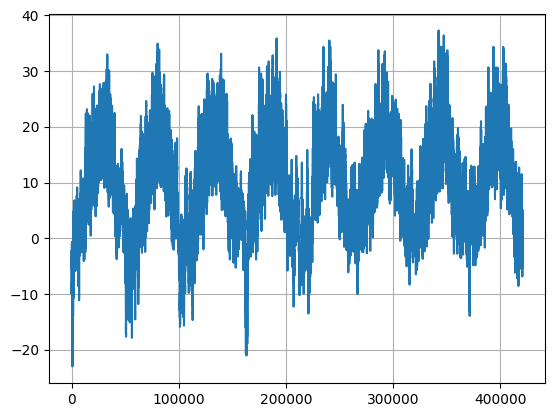

In [21]:
temp = float_data[:, 1]
print(float_data[:,1])
 
#TODO: Plot whole temperature series, notice yearly 
import matplotlib.pyplot as plt

plt.plot(temp)
plt.grid(True)
plt.show()

#TODO: Plot the first few days

In [22]:
train_samples = 200000

#TODO: Normalize the data
for i in range(float_data.shape[1]):
    col = float_data[:,i]
    col_train = float_data[:train_samples,i]
    col = (col - np.mean(col_train)) / np.std(col_train)
    float_data[:,i] = col
    
print(float_data[:,1])

[-1.93135845 -1.97541381 -1.98671006 ... -1.38236094 -1.50323076
 -1.56987861]


In [23]:
# generator function used to feed the training, validation and test data
 
def generator(data, lookback, delay, min_index, max_index,
                shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                    min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
 
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [ ]:
#TODO Define lookback, step, delay and batch size variable
lookback = 720
delay=144
batch_size=128
step=6
val_samples = 100000

train_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index=train_samples,
                        shuffle=True,
                        step=step,
                        batch_size=batch_size)
 
#TODO: Set a validation generator similar to train generator. Use next 100000 samples (max index from 200,000 to 300,000). Do not shuftle the data:
 
val_gen =  generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=train_samples,
                        max_index=train_samples + val_samples,
                        shuffle=False,
                        step=step,
                        batch_size=batch_size)
 
#TODO: Set a validation generator similar to a train generator. Use further next 100000 samples (max index from 300,000 onwards). Do not shuffle the data:
test_gen =  generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=train_samples + val_samples,
                        max_index=len(float_data) - 1,
                        shuffle=True,
                        step=step,
                        batch_size=batch_size)

In [25]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
 
model.compile(optimizer=RMSprop(), loss='mae')
 
# Number of steps to draw from val_gen to see the entire validation set
val_steps = (300000 - 200001 - lookback)//batch_size 
 
#TODO: Train the network for about 20 epochs
history = model.fit(
    train_gen, 
    batch_size=batch_size, 
    epochs=20, 
    steps_per_epoch=int(np.ceil(train_samples / batch_size)), 
    validation_data=val_gen, 
    validation_steps=val_steps, 
    validation_batch_size=128)



d:\programowanie\Python\ML2\ml_env\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 0.7026 - val_loss: 0.2854
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - loss: 0.2650 - val_loss: 0.3218
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - loss: 0.2442 - val_loss: 0.2859
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 0.2342 - val_loss: 0.3050
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - loss: 0.2285 - val_loss: 0.2910
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.2215 - val_loss: 0.3227
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - loss: 0.2187 - val_loss: 0.3068
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - loss: 0.2137 - val_loss: 0.2961
Epoch 9/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.2094 - val_loss: 0.3055
Epoch 10/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.2067 - val_loss: 0.3234
Epoch 11/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.2035 - val_loss: 0.3141
Epoch 12

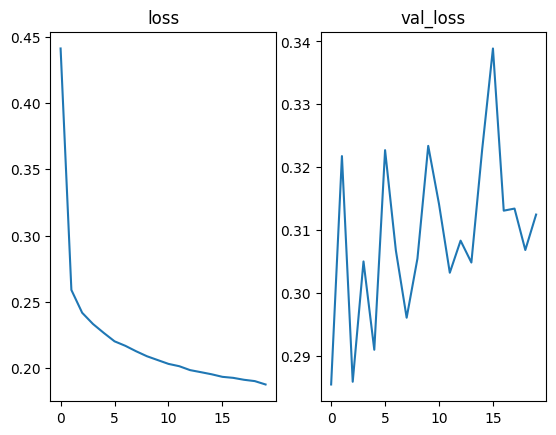

In [29]:
#TODO: Plot the results
def plot_metrics(history):
    history_dict = history.history
    # print(history_dict.keys())

    _, ax = plt.subplots(1, 2)
    ax[0].plot(history_dict['loss'])
    ax[0].set_title('loss')
    ax[1].plot(history_dict['val_loss'])
    ax[1].set_title('val_loss')
    plt.show()
    
plot_metrics(history)

Epoch 1/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 50ms/step - loss: 0.3400 - val_loss: 0.2730
Epoch 2/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 76s 48ms/step - loss: 0.3017 - val_loss: 0.2736
Epoch 3/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - loss: 0.2903 - val_loss: 0.2676
Epoch 4/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 74s 47ms/step - loss: 0.2845 - val_loss: 0.2646
Epoch 5/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 68s 44ms/step - loss: 0.2812 - val_loss: 0.2644
Epoch 6/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1624s 1s/step - loss: 0.2768 - val_loss: 0.2701
Epoch 7/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - loss: 0.2734 - val_loss: 0.2665
Epoch 8/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - loss: 0.2714 - val_loss: 0.2667
Epoch 9/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - loss: 0.2698 - val_loss: 0.2667
Epoch 10/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 72s 46ms/step - loss: 0.2685 - val_loss: 0.2638
Epoch 11/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 71s 46ms/step - loss: 0.2650 - val_loss: 0.2693
Epoch 12

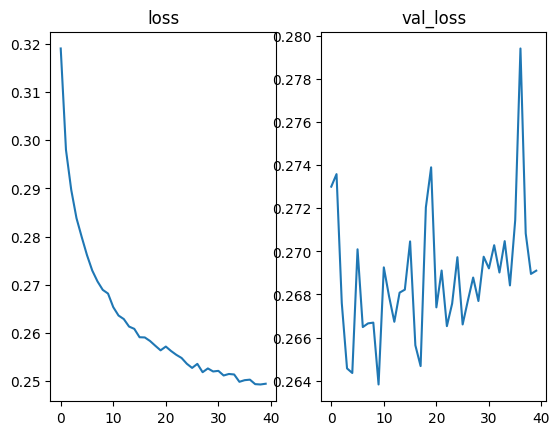

In [32]:
model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
# model.add(layers.GRU(32))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
 
#TODO: Train the network for about 20 epochs
history = model.fit(
    train_gen, 
    batch_size=batch_size, 
    epochs=40, 
    steps_per_epoch=int(np.ceil(train_samples / batch_size)), 
    validation_data=val_gen, 
    validation_steps=val_steps, 
    validation_batch_size=128)

plot_metrics(history)

Epoch 1/40


d:\programowanie\Python\ML2\ml_env\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 104s 65ms/step - loss: 0.3023 - val_loss: 0.2717
Epoch 2/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 54ms/step - loss: 0.2606 - val_loss: 0.2811
Epoch 3/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 89s 57ms/step - loss: 0.2430 - val_loss: 0.2812
Epoch 4/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 53ms/step - loss: 0.2214 - val_loss: 0.2934
Epoch 5/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - loss: 0.2034 - val_loss: 0.3106
Epoch 6/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 79s 50ms/step - loss: 0.1875 - val_loss: 0.3138
Epoch 7/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 53ms/step - loss: 0.1749 - val_loss: 0.3198
Epoch 8/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 77s 49ms/step - loss: 0.1650 - val_loss: 0.3293
Epoch 9/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 77s 49ms/step - loss: 0.1566 - val_loss: 0.3328
Epoch 10/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 77s 49ms/step - loss: 0.1506 - val_loss: 0.3291
Epoch 11/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 76s 49ms/step - loss: 0.1457 - val_loss: 0.3344
Epoch 12/40
1563/1

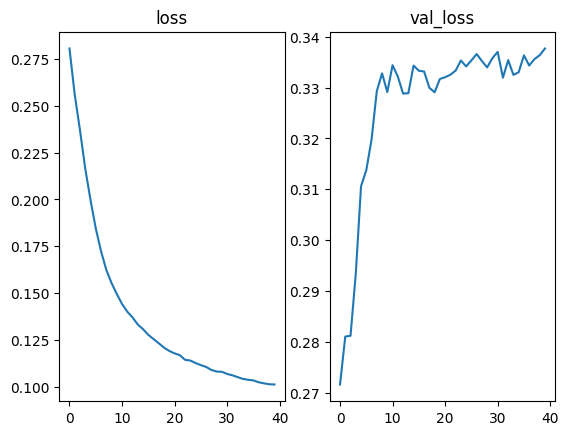

ValueError: Input 0 of layer "bidirectional_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 1)

In [33]:
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
 
# Number of steps to draw from val_gen to see the entire validation set
val_steps = (300000 - 200001 - lookback)//batch_size 
 
#TODO: Train the network for about 20 epochs
history = model.fit(
    train_gen, 
    batch_size=batch_size, 
    epochs=40, 
    steps_per_epoch=int(np.ceil(train_samples / batch_size)), 
    validation_data=val_gen, 
    validation_steps=val_steps, 
    validation_batch_size=128)

plot_metrics(history)

model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))

In [ ]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
 
# Number of steps to draw from val_gen to see the entire validation set
val_steps = (300000 - 200001 - lookback)//batch_size 
 
#TODO: Train the network for about 20 epochs
history = model.fit(
    train_gen, 
    batch_size=batch_size, 
    epochs=40, 
    steps_per_epoch=int(np.ceil(train_samples / batch_size)), 
    validation_data=val_gen, 
    validation_steps=val_steps, 
    validation_batch_size=128)

plot_metrics(history)

model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))